# **Computational Drug Discovery**

The goal of this project is to use data from the ChEMBL Database to train a model that can predict the activity of a potential drug based on its chemical properties. This can be used to study the atoms and atomic groups that are critical in the drug effectiveness.

In this project I will focus on studying possible drugs targeting proteins with a role in **prostate cancer** development.

*Note: November and the movember movement inspired me to do this project. This movement that try to raise awareness of men's health issues, such as prostate cancer during the month of November. [Read more about movember here](https://en.wikipedia.org/wiki/Movember).*

**Import Libraries**

In [133]:
# Data Handling
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from scipy import stats
import os
import glob
import datetime as dt

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns
from IPython.display import Image
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Lipinski Descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.feature_selection import VarianceThreshold

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Assesing model performance
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score

# Tunning
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Library to render the pyplots on github

import plotly.io as pio


## 1. Downloading Bioactivity Data from ChEMBL

**1.1 Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.**

[*ChEMBL Database*](https://www.ebi.ac.uk/chembl/) is a database that contains curated bioactivity data of more than 2 million compounds. It is compiled from more than 76,000 documents, 1.2 million assays and the data spans 13,000 targets and 1,800 cells and 33,000 indications.

In [2]:
# ! pip install chembl_webresource_client

**1.2 Target search for prostate cancer**

In [3]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('prostate cancer')
#target_query = target.search('aromatase')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Alpha-ketoglutarate-dependent dioxygenase alkB...,18.0,False,CHEMBL3112376,"[{'accession': 'Q96Q83', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,"[{'xref_id': 'O75387', 'xref_name': None, 'xre...",Homo sapiens,L-type amino acid transporter 3,17.0,False,CHEMBL4148,"[{'accession': 'O75387', 'component_descriptio...",SINGLE PROTEIN,9606.0
2,[],Rattus norvegicus,Prostate,17.0,False,CHEMBL613656,[],TISSUE,10116.0
3,"[{'xref_id': 'P07288', 'xref_name': None, 'xre...",Homo sapiens,Prostate specific antigen,16.0,False,CHEMBL2099,"[{'accession': 'P07288', 'component_descriptio...",SINGLE PROTEIN,9606.0
4,[],Homo sapiens,Prostate cells,15.0,False,CHEMBL614850,[],CELL-LINE,9606.0
...,...,...,...,...,...,...,...,...,...
70,[],Homo sapiens,Mucin-1,4.0,False,CHEMBL3580494,"[{'accession': 'P15941', 'component_descriptio...",SINGLE PROTEIN,9606.0
71,[],Homo sapiens,Interleukin 13 receptor,4.0,False,CHEMBL3831285,"[{'accession': 'P24394', 'component_descriptio...",PROTEIN COMPLEX,9606.0
72,[],Homo sapiens,Aurora kinase A/Targeting protein for Xklp2,3.0,False,CHEMBL3883304,"[{'accession': 'O14965', 'component_descriptio...",PROTEIN COMPLEX,9606.0
73,[],Homo sapiens,Mitochondrial complex I (NADH dehydrogenase),0.0,False,CHEMBL2363065,"[{'accession': 'P03923', 'component_descriptio...",PROTEIN COMPLEX,9606.0


For instance: **Prostate Specific Antigen (PSA)** (See 3D structure below), is a protein is present in small quantities in the serum of men with healthy prostates, but is often elevated in the presence of prostate cancer or other prostate disorders. Hence, the levels of PSA in blood are often used as a diagnostic tool for early detection of prostate cancer.

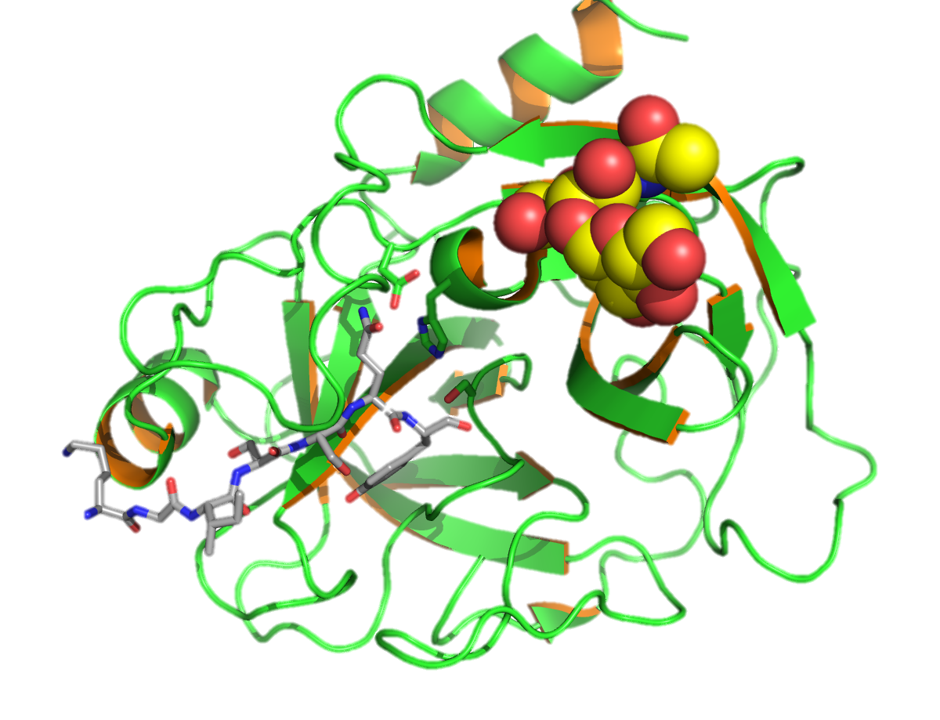

In [4]:
Image(filename='figures/PSA.png', width=250, height=250) 

Lets keep the ones from **humans** only and let's focus on **molecular targets** (protein and protein-complexes only)

In [5]:
targets = targets.loc[(targets["organism"] == "Homo sapiens")&((targets["target_type"] == ("SINGLE PROTEIN"))|(targets["target_type"] == ("PROTEIN COMPLEX")))]	

**1.3 Select and retrieve bioactivity data for compounds against all human prostate targets**

We will assign the first entry (which corresponds to the target protein, *human prostate specific antigen*) to the ***selected_target*** variable 

In [6]:
selected_targets = targets.target_chembl_id[0:]
selected_targets 
# Target ID for this protein is 'CHEMBL2099' (Unique Identificator)

0     CHEMBL3112376
1        CHEMBL4148
3        CHEMBL2099
5     CHEMBL3712961
6     CHEMBL4295936
7        CHEMBL5990
8     CHEMBL3712956
10       CHEMBL5261
11       CHEMBL5475
12       CHEMBL5578
13    CHEMBL1075195
14    CHEMBL3713916
24    CHEMBL1795185
25       CHEMBL2106
27    CHEMBL1764945
28    CHEMBL2150837
29    CHEMBL3580482
30    CHEMBL4105704
31    CHEMBL4296022
36       CHEMBL5660
37    CHEMBL1163126
38    CHEMBL1795198
39    CHEMBL2021752
40    CHEMBL3120039
41    CHEMBL3632454
42    CHEMBL3879825
43    CHEMBL4295952
44       CHEMBL1892
45       CHEMBL2633
47       CHEMBL4899
48       CHEMBL5639
49    CHEMBL2046267
52    CHEMBL3627582
53    CHEMBL3774295
55       CHEMBL4896
56       CHEMBL5393
57       CHEMBL5877
58    CHEMBL2295562
60       CHEMBL3886
61    CHEMBL1615382
62    CHEMBL2146355
64    CHEMBL3885534
65    CHEMBL4105856
67       CHEMBL5389
68    CHEMBL2052032
70    CHEMBL3580494
71    CHEMBL3831285
72    CHEMBL3883304
73    CHEMBL2363065
74    CHEMBL2364701


Here, we will retrieve only bioactivity data that are reported **as IC$_{50}$** values in nM (nanomolar) unit. Using the same bioactivity unit (IC50) makes our data set more uniform. A low IC50 means that the drug concentration needs to be low to obtain 50% inhibition of the target protein. Hence, IC50 **the lower, the better**.

In [ ]:
df_dict = {} # Use a dict to save all df 

for target in selected_targets:
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")
    df = pd.DataFrame.from_dict(res)
    df_dict[target] = df

In [ ]:
dfs = pd.concat(df_dict, axis=0)

In [ ]:
dfs = dfs.reset_index()

In [ ]:
dfs.shape

In [ ]:
dfs.standard_type.unique()

Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [12]:
# So the list of possible cancer prostate targets are:
list(dfs["target_pref_name"].unique())

['Alpha-ketoglutarate-dependent dioxygenase alkB homolog 3',
 'L-type amino acid transporter 3',
 'Prostate specific antigen',
 'Breast cancer type 1 susceptibility protein',
 'Serine/threonine-protein kinase TAO1',
 'Cyclin-dependent kinase 2-associated protein 1',
 'Serine/threonine-protein kinase TAO2',
 'Ovarian cancer G-protein coupled receptor 1',
 'Bromodomain testis-specific protein',
 'PHD finger protein 13',
 'ATPase family AAA domain-containing protein 2',
 'Serine/threonine-protein kinase ICK',
 'Kinesin-like protein KIF20B',
 'tRNA-dihydrouridine(20) synthase [NAD(P)+]-like',
 'Glutamate carboxypeptidase II',
 'Prostatic acid phosphatase',
 'Mitogen-activated protein kinase kinase kinase 8',
 'Serine/threonine-protein kinase WNK2',
 'Anoctamin-1',
 'Testis-specific serine/threonine-protein kinase 6',
 'Lysine-specific demethylase 5B',
 'PDZ-binding kinase',
 'ATP-binding cassette sub-family G member 2',
 'Beta-hexosaminidase subunit beta',
 'Dual specificity protein phosph

In [13]:
dfs.to_csv('data/bioactivity_data.csv', index=False)

## 2. Data Cleaning and Preprocessing

**2.1 Handling nan values: If any compounds has missing value for the standard_value column then drop it**

In [2]:
df = pd.read_csv("data/bioactivity_data.csv")

In [3]:
df = df.dropna(subset=["standard_value"])
df = df.reset_index(drop=True)

**2.2 Create a new df using molecule_chembl_id, canonical_smiles, bioactivity class and standard_value columns** 

To create the bioactivity column we will def a function to label the compounds as either being active, inactive or intermediate.

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [4]:
def bioactivity_class_maker(item):
    if float(item) >= 10000:
        return "inactive"
    elif float(item) <= 1000:
        return "active"
    else:
        return "intermediate"

In [5]:
df2 = df[["target_pref_name", "molecule_chembl_id", "canonical_smiles", "standard_value"]]

In [6]:
df2["bioactivity_class"] = df2["standard_value"].apply(bioactivity_class_maker)

Saving dataframe to CSV file

In [7]:
df2.to_csv('data/bioactivity_preprocessed_data.csv', index=False)

In [8]:
# conda install -c rdkit rdkit -y

In [9]:
df = pd.read_csv('data/bioactivity_preprocessed_data.csv')

**2.3 Calculate Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a **set of rules** for evaluating the **druglikeness** of compounds. Such druglikeness is based on the the following pharmakinetic properties:
* Absorption
* Distribution
* Metabolism
* Excretion (ADME).
This comprise the **pharmacokinetic profile**. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**. This drug properties largely determine how well the drug will be absorbed, distributed to the target tissue, become metabolized and excreted from the body.

The Lipinski's Rule stated that to be an effective drug would meet the following criteria:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

In [10]:
df = df.dropna(subset=["canonical_smiles"]).reset_index(drop=True)

In [11]:
#df["canonical_smiles"] = df["canonical_smiles"].str.replace("@", "O")

In [12]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

"""The function below takes the data from the canonical_smiles column that contains the molecular formula of each compound,
and returns a dataframe containing the lipinski parameters:
MW (molec. weight), 
Log P (solubility), 
NumHDonors and NumHAceptors (relative number of H-bond donors and aceptors, respectively)"""

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [13]:
df_lipinski = lipinski(df["canonical_smiles"])

In [14]:
df = pd.concat([df, df_lipinski], axis=1)

In [15]:
df

,target_pref_name,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145420,Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C,10000.0,inactive,332.407,3.55796,2.0,3.0
1,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145438,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl,10000.0,inactive,373.243,4.24792,2.0,3.0
2,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145437,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1,10000.0,inactive,338.798,3.59452,2.0,3.0
3,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145418,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl,10000.0,inactive,338.798,3.59452,2.0,3.0
4,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145434,O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...,10000.0,inactive,366.424,4.29970,2.0,3.0
...,...,...,...,...,...,...,...,...,...
3370,26S proteasome,CHEMBL491636,CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)N[C@H]1C[C@H...,1440.0,intermediate,369.418,-0.61450,4.0,6.0
3371,26S proteasome,CHEMBL3237860,CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)N[C@H]1C[C@@...,5.7,active,563.695,3.90140,3.0,6.0
3372,26S proteasome,CHEMBL3237861,CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)NCCC(COCc1cc...,29.0,active,453.579,4.13020,1.0,5.0
3373,26S proteasome,CHEMBL3291290,CC(=O)N[C@@H](CC(=O)NCCC(COCc1ccccc1)COCc1cccc...,2300.0,intermediate,609.764,3.32620,3.0,7.0


**2.4 Convert IC50 to pIC50**

This is a data **transformation step** to make our data more uniformly distributed. 
**IC50** -> to the negative logarithmic scale **-log10(IC50)**.

We need two functions:

    1) Def a func that take large numbers and converts them to 100.000.000 because otherwise, when we tranform the data these values would turn negative.
    
    2) Def a func that transforms standard_value to the negative log scale:
           * Converts  standard_value from nM to M by multiplying the value by 10$^{-9}$
           * Take the molar value and apply -log10

In [16]:
def capping_large_values(item):
    if item > 100000000:
        return 100000000
    else:
        return item

In [17]:
df["standard_value"] = df["standard_value"].apply(capping_large_values)

In [18]:
len(df.loc[df["standard_value"] == 100000000]) # no values needed to be capped

0

In [19]:
def neg_log_transformation(item):
    item = item*(10**-9) # 1
    return -np.log10(item) # 2

In [20]:
df["standard_value_transformed"] = df["standard_value"].apply(neg_log_transformation)

In [21]:
df[df["standard_value_transformed"]<0] # indeed we do not get negative values 

,target_pref_name,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed


Lets check the data distribution of the IC50 values before and after the transformation

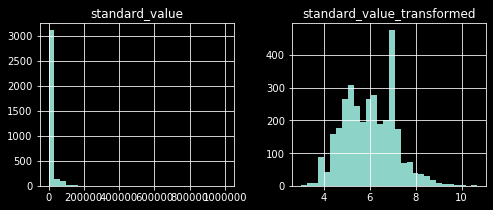

In [22]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,3)
df[["standard_value", "standard_value_transformed"]].hist(bins=30)
#plt.savefig("figures/negative_log_transformation.png", dpi=300, bbox_inches="tight")
plt.show()

we can now drop the ``standard_value`` column

In [23]:
df = df.drop("standard_value", axis=1)

At this point we will create one df for the EDA part containing only active and inactive molecules to see what are the differences between both groupss. For this we will drop the intermediate class from the ``bioactivity_class`` column.

In [24]:
df_EDA = df[~(df["bioactivity_class"] == "intermediate")]

In [25]:
df_EDA = df_EDA.reset_index(drop=True)

In [26]:
df_EDA

,target_pref_name,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145420,Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C,inactive,332.407,3.55796,2.0,3.0,5.000000
1,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145438,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl,inactive,373.243,4.24792,2.0,3.0,5.000000
2,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145437,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1,inactive,338.798,3.59452,2.0,3.0,5.000000
3,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145418,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl,inactive,338.798,3.59452,2.0,3.0,5.000000
4,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145434,O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...,inactive,366.424,4.29970,2.0,3.0,5.000000
...,...,...,...,...,...,...,...,...,...
2422,26S proteasome,CHEMBL3262766,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)C[C@@H...,active,619.762,5.31740,3.0,5.0,6.958607
2423,26S proteasome,CHEMBL325041,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...,active,384.245,0.36060,4.0,6.0,8.146302
2424,26S proteasome,CHEMBL451887,CC(C)C[C@H](NC(=O)[C@H](CCc1ccccc1)NC(=O)CN1CC...,active,719.924,2.58350,4.0,8.0,8.065502
2425,26S proteasome,CHEMBL3237860,CC[C@H](C)[C@@H]1C(=O)O[C@H]1C(=O)N[C@H]1C[C@@...,active,563.695,3.90140,3.0,6.0,8.244125


Now I will safe the df with all the data. We will come back to it during the modeling part

In [27]:
df.to_csv('data/lipinski_data.csv', index=False)

In [28]:
df = pd.read_csv("data/lipinski_data.csv")

In [29]:
df.head()

,target_pref_name,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145420,Cc1ccc2[nH]c(-n3[nH]c(C)c(Cc4ccccc4)c3=O)nc2c1C,inactive,332.407,3.55796,2.0,3.0,5.0
1,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145438,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1Cl,inactive,373.243,4.24792,2.0,3.0,5.0
2,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145437,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccc(Cl)cc1,inactive,338.798,3.59452,2.0,3.0,5.0
3,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145418,Cc1[nH]n(-c2nc3ccccc3[nH]2)c(=O)c1Cc1ccccc1Cl,inactive,338.798,3.59452,2.0,3.0,5.0
4,Alpha-ketoglutarate-dependent dioxygenase alkB...,CHEMBL3145434,O=c1c(Cc2ccccc2)c(-c2ccccc2)[nH]n1-c1nc2ccccc2...,inactive,366.424,4.29970,2.0,3.0,5.0


## 3. Exploratory Data Analysis:  
**Chemical Space Analysis using the Lipinski descriptors**

**3.1. Lets plot the frequency distribution of the two bioactivity classes**

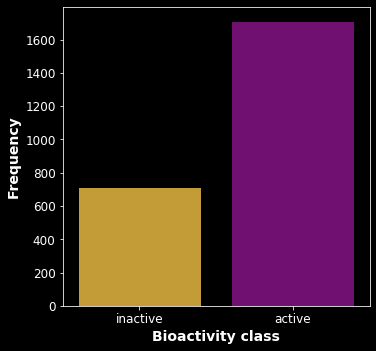

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_EDA, palette = ["goldenrod", "purple"], edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('figures/plot_bioactivity_class.png', dpi=300, bbox_inches="tight")
plt.show()

**3.2 Next lets do a scatter plot of the MW vs the solubility to see the relactionship between these two features**

In [31]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_EDA['MW'],df_EDA['LogP'])

In [32]:
slope

0.004310648135502124

In [33]:
intercept

1.9029421901917214

In [34]:
r_value = round(r_value,2)

In [35]:
r_value

0.25

In [36]:
p_value

1.1698854733545527e-36

In [37]:
x = np.linspace(100,1700,100)
y = slope*x+intercept # defining the equation to plot the trending line together with the scatterplot

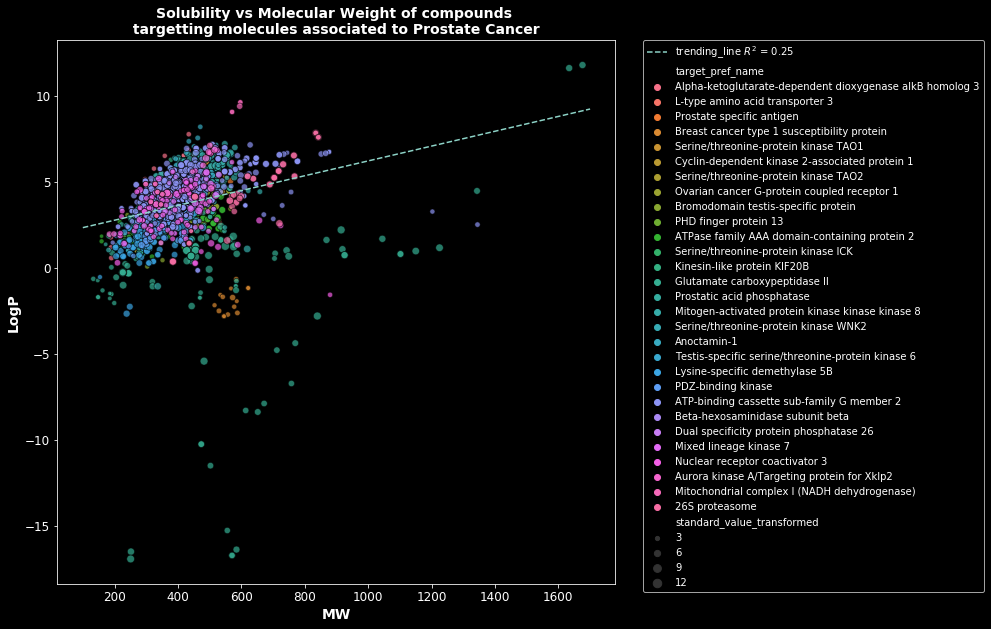

In [38]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x='MW', y='LogP', data=df_EDA, hue='target_pref_name', size='standard_value_transformed', edgecolor='black', alpha=0.7)
plt.plot(x, y,  '--', label='trending_line $R^2$ = {}'.format(r_value))
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1),  loc=2, borderaxespad=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Solubility vs Molecular Weight of compounds \n targetting molecules associated to Prostate Cancer ", fontsize=14, fontweight='bold')
# plt.savefig('figures/plot_MW_vs_LogP.png', dpi=300, bbox_inches="tight")
plt.show()

**3.3 Use boxplots to see the value distributions within each bioactive class**

In [39]:
df_EDA = df_EDA.sort_values(by=["target_pref_name", "bioactivity_class"])

In [40]:
df_active_vs_inactive = pd.pivot_table(data=df_EDA, index=["target_pref_name", "bioactivity_class"], values="standard_value_transformed",
        aggfunc = ["mean","count", "std"]).reset_index()

In [41]:
df_active_vs_inactive.columns = ["target_name", "bioactivity_class", "mean_pCI50", "number of potential drugs", "std"]

In [42]:
df_active_vs_inactive.sort_values(by=["bioactivity_class","number of potential drugs","target_name"],
                                  ascending=[True, False, True]).reset_index(drop=True)

,target_name,bioactivity_class,mean_pCI50,number of potential drugs,std
0,ATP-binding cassette sub-family G member 2,active,6.542876,514,0.395154
1,Lysine-specific demethylase 5B,active,7.022058,434,0.450795
2,Mitogen-activated protein kinase kinase kinase 8,active,7.253563,191,0.692827
3,Glutamate carboxypeptidase II,active,7.648947,141,1.054492
4,Serine/threonine-protein kinase TAO1,active,6.915112,119,0.488263
5,PDZ-binding kinase,active,6.706240,68,0.591532
6,ATPase family AAA domain-containing protein 2,active,6.789362,47,0.386870
7,26S proteasome,active,7.354350,45,0.821879
8,Bromodomain testis-specific protein,active,6.655502,38,0.485977
9,Anoctamin-1,active,6.550490,30,0.370112


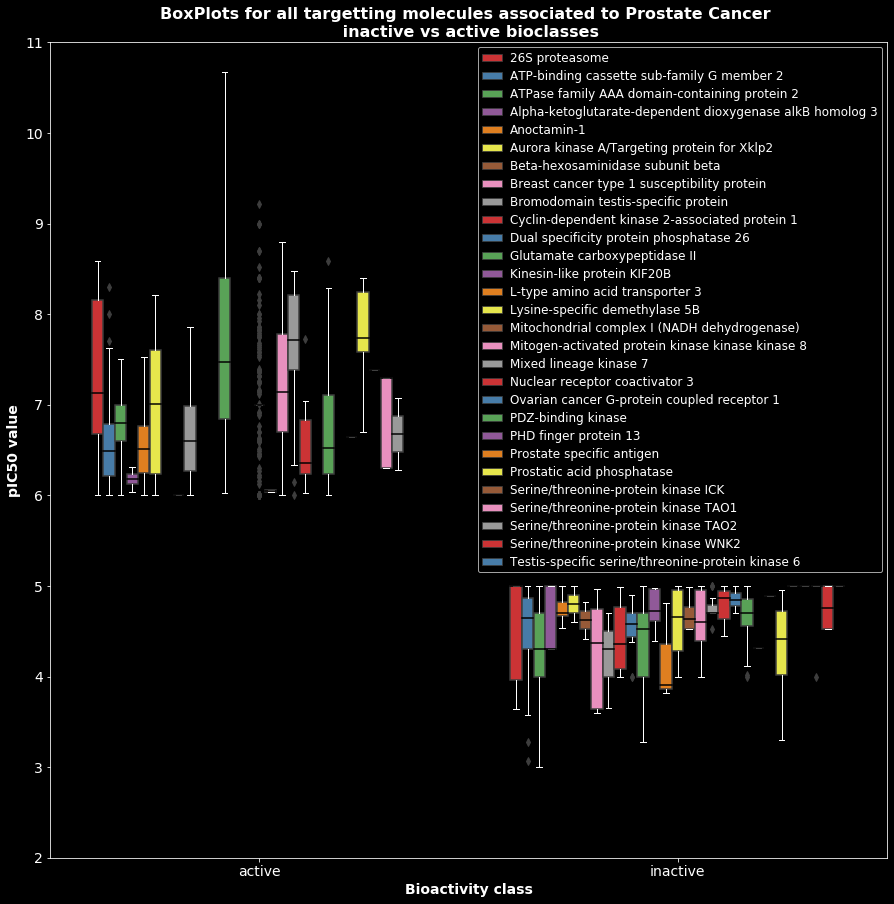

In [43]:
plt.figure(figsize=(15, 15))

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="black",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)
col_palette = sns.color_palette("Set1")
sns.boxplot(x = 'bioactivity_class', y = 'standard_value_transformed', hue='target_pref_name', palette=col_palette, data = df_EDA,
            capprops=capprops, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)
plt.setp(plt.legend().get_texts(), fontsize='12') 

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("BoxPlots for all targetting molecules associated to Prostate Cancer \n inactive vs active bioclasses", fontsize=16, fontweight='bold')
plt.ylim((2,11))

#plt.savefig('figures/plot_ic50.png', dpi=300, bbox_inches="tight")
plt.show()

**3.4 Statistical analysis | Mann-Whitney U Test**

We will use a **mann-whitney** u test to check for statistical significance between each of the Lipinski variables for each of the prostate cancer target groups

In [44]:
def mannwhitney(descriptor, verbose=False):
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

# seed the random number generator
    seed(1)

# actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df2 = df3[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df2 = df3[selection]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

# compare samples
    stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
    alpha = 0.05
    
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Molec_group': i,
                              'Statistics':stat,
                              'p':p,
                              'alpha':alpha,
                              'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor +"_"+ i + '.csv'
    results.to_csv("statistical_tests/{}".format(filename))

    return results

I will select those molecular groups with **at least 10 values in each bioactivity class** and save them in a **list_molec_groups** variable.
Then I will use this list to perform a mann whitney test for each of the lipinski parameters for each molec_group

In [45]:
df_active_vs_inactive

,target_name,bioactivity_class,mean_pCI50,number of potential drugs,std
0,26S proteasome,active,7.354350,45,0.821879
1,26S proteasome,inactive,4.522879,5,0.662974
2,ATP-binding cassette sub-family G member 2,active,6.542876,514,0.395154
3,ATP-binding cassette sub-family G member 2,inactive,4.550439,197,0.379131
4,ATPase family AAA domain-containing protein 2,active,6.789362,47,0.386870
5,ATPase family AAA domain-containing protein 2,inactive,4.348843,56,0.417396
6,Alpha-ketoglutarate-dependent dioxygenase alkB...,active,6.185997,18,0.076142
7,Alpha-ketoglutarate-dependent dioxygenase alkB...,inactive,4.575892,38,0.334190
8,Anoctamin-1,active,6.550490,30,0.370112
9,Anoctamin-1,inactive,4.740988,28,0.136761


In [46]:
df_10 = df_active_vs_inactive[(df_active_vs_inactive["number of potential drugs"] >= 10)]

In [47]:
df_10

,target_name,bioactivity_class,mean_pCI50,number of potential drugs,std
0,26S proteasome,active,7.354350,45,0.821879
2,ATP-binding cassette sub-family G member 2,active,6.542876,514,0.395154
3,ATP-binding cassette sub-family G member 2,inactive,4.550439,197,0.379131
4,ATPase family AAA domain-containing protein 2,active,6.789362,47,0.386870
5,ATPase family AAA domain-containing protein 2,inactive,4.348843,56,0.417396
6,Alpha-ketoglutarate-dependent dioxygenase alkB...,active,6.185997,18,0.076142
7,Alpha-ketoglutarate-dependent dioxygenase alkB...,inactive,4.575892,38,0.334190
8,Anoctamin-1,active,6.550490,30,0.370112
9,Anoctamin-1,inactive,4.740988,28,0.136761
10,Aurora kinase A/Targeting protein for Xklp2,active,6.979054,14,0.791235


In [48]:
df_10 = pd.pivot_table(data=df_10, index=["target_name"], values = ["bioactivity_class"],
        aggfunc = ["count"]).reset_index()

In [49]:
df_10.columns = ["target_name", "bioactivity_class"]

In [50]:
list_molec_groups = list(df_10.loc[(df_10["bioactivity_class"]==2)].target_name)

In [51]:
lipinski_parameters = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]

In [52]:
for i in list_molec_groups:
    for j in lipinski_parameters:
        df3 = df_EDA.loc[df["target_pref_name"]==i]
        mannwhitney(j)

Lets combine all the csv files into one single file.

In [ ]:
os.chdir(r"E:\Projects\GitHub_drug_discovery\statistical_tests") # Setting the working directory

In [250]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*')]

In [251]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv("all_tests_combined.csv", index=False, encoding='utf-8-sig') 

In [62]:
results_tests = pd.read_csv("statistical_tests/all_tests_combined.csv")

In [55]:
os.chdir(r"E:\Projects\GitHub_drug_discovery") # back to the project directory

In [56]:
df_molec_groups_10plus = df_EDA[df_EDA["target_pref_name"].isin(list_molec_groups)].reset_index(drop=True)

In [57]:
df_molec_groups_10plus

,target_pref_name,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_transformed
0,ATP-binding cassette sub-family G member 2,CHEMBL221371,COc1cc(O)c2c(=O)c3c(oc2c1)C(OC)Oc1c(O)cccc1-3,active,342.303,2.9172,2.0,7.0,6.154902
1,ATP-binding cassette sub-family G member 2,CHEMBL243168,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccc(OC)cc4[nH]c2...,active,402.450,3.6710,2.0,4.0,6.251812
2,ATP-binding cassette sub-family G member 2,CHEMBL243167,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1OC,active,402.450,3.6710,2.0,4.0,6.346787
3,ATP-binding cassette sub-family G member 2,CHEMBL397235,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1,active,372.424,3.6624,2.0,3.0,6.455932
4,ATP-binding cassette sub-family G member 2,CHEMBL242513,COc1cc(C(F)(F)F)cc2[nH]c3ccccc3c(=O)c12,active,293.244,3.7087,1.0,2.0,6.113509
...,...,...,...,...,...,...,...,...,...
2144,Prostatic acid phosphatase,CHEMBL299737,O=P(O)(O)Cc1ccccc1,inactive,172.120,1.3643,2.0,1.0,3.301030
2145,Prostatic acid phosphatase,CHEMBL325368,O=P(O)(O)C1c2ccccc2C=Cc2ccccc21,inactive,272.240,3.4375,2.0,1.0,4.000000
2146,Prostatic acid phosphatase,CHEMBL107858,O=P(O)(O)C(Cc1ccc(-c2ccccc2)cc1)c1cccc(C(F)(F)...,inactive,406.340,5.8339,2.0,1.0,4.443697
2147,Prostatic acid phosphatase,CHEMBL107540,O=P(O)(O)C(Cc1ccccc1)c1cccc(C(F)(F)F)c1,inactive,330.242,4.1669,2.0,1.0,4.000000


In [58]:
df_molec_groups_10plus.to_csv("data/df_bioclass_atleast10.csv", index=False)

In [63]:
results_tests = results_tests.drop("Unnamed: 0", axis=1)

In [64]:
stat_differences = results_tests.loc[results_tests["p"]<= 0.05]

In [65]:
results_tests

,Descriptor,Molec_group,Statistics,p,alpha,Interpretation
0,LogP,Alpha-ketoglutarate-dependent dioxygenase alkB...,560965.5,0.000527,0.05,Different distribution (reject H0)
1,LogP,Anoctamin-1,560965.5,0.000527,0.05,Different distribution (reject H0)
2,LogP,ATP-binding cassette sub-family G member 2,560965.5,0.000527,0.05,Different distribution (reject H0)
3,LogP,ATPase family AAA domain-containing protein 2,560965.5,0.000527,0.05,Different distribution (reject H0)
4,LogP,Bromodomain testis-specific protein,560965.5,0.000527,0.05,Different distribution (reject H0)
...,...,...,...,...,...,...
91,NumHDonors,Mitogen-activated protein kinase kinase kinase 8,581675.0,0.019877,0.05,Different distribution (reject H0)
92,NumHDonors,Mixed lineage kinase 7,581675.0,0.019877,0.05,Different distribution (reject H0)
93,NumHDonors,Nuclear receptor coactivator 3,581675.0,0.019877,0.05,Different distribution (reject H0)
94,NumHDonors,PDZ-binding kinase,581675.0,0.019877,0.05,Different distribution (reject H0)


stat_differences: All comparissons yielded statitically differences at the 5% level

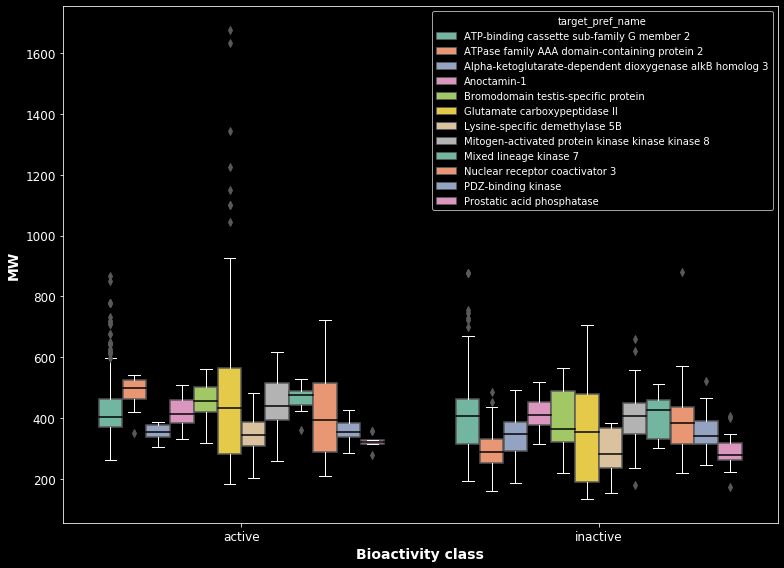

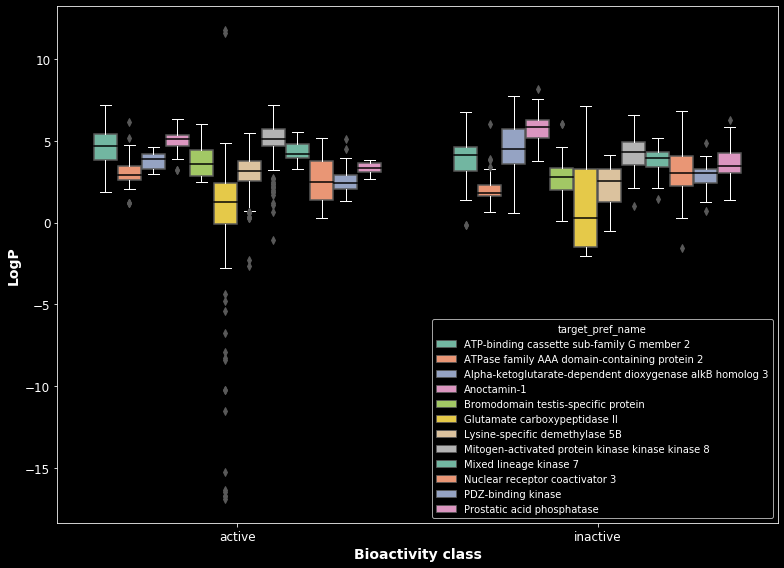

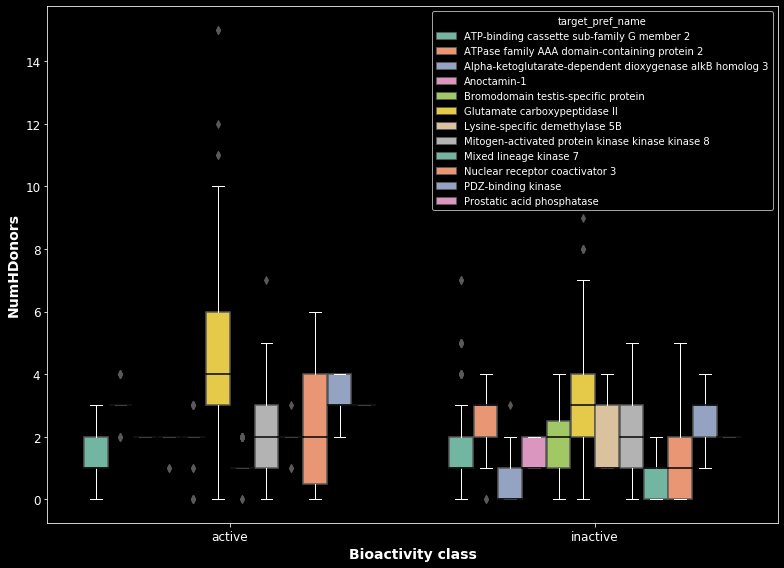

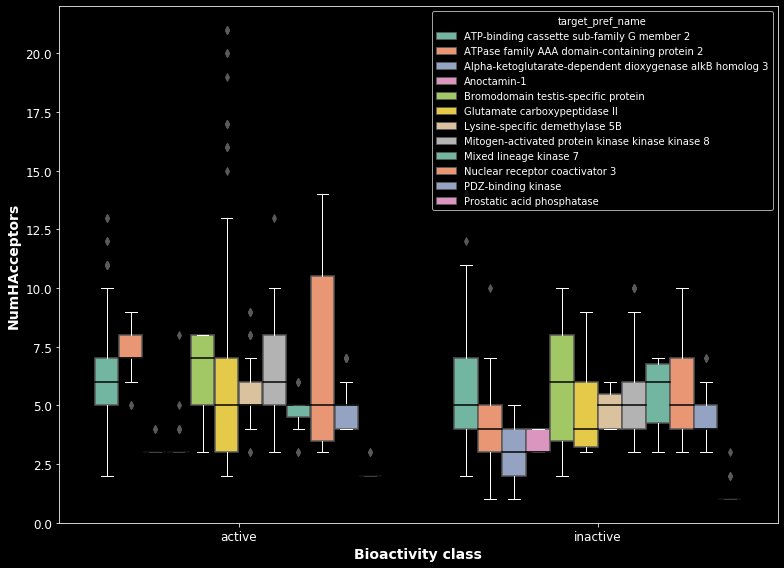

In [66]:
for i in lipinski_parameters:

    plt.figure(figsize=(11, 8))

    boxprops = dict(color="white",linewidth=1)
    medianprops = dict(color="black",linewidth=1.5)
    whiskerprops = dict(color="white",linewidth=1)
    capprops = dict(color="white",linewidth=1)
    flierprops = dict(color="yellow",linewidth=1)
    col_palette = sns.color_palette("Set2")
    sns.boxplot(x = 'bioactivity_class', y = i, palette=col_palette, hue="target_pref_name", data = df_molec_groups_10plus,
                capprops=capprops, flierprops=flierprops, whiskerprops=whiskerprops, medianprops=medianprops)

    plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
    plt.ylabel(i, fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    #plt.savefig("figures/{}_vs_activity.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()

**3.5 Interpretation of Statistical Results**

**Lipinski's descriptors**

All the Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), exhibited ***statistical difference (*p* < 0.05)** between the **actives** and **inactives** for all the molec. groups with more than 20 potential drug compounds (active and inactive)

In [55]:
# ! zip -r results.zip . -i *.csv *.pdf ## To zip the files

## 4. Dataset Preparation

**4.1 Calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset.**

In [67]:
df = pd.read_csv("data/lipinski_data.csv")

In [68]:
df.shape

(3375, 9)

In [69]:
df_select = df[["canonical_smiles","molecule_chembl_id"]]

In [70]:
df_select.to_csv('padel/molecule.smi', sep='\t', index=False, header=False)

* Using the **Padel- Descriptor Software** developed by the authors of [this paper](http://onlinelibrary.wiley.com/doi/10.1002/jcc.21707/abstract), we calculated the fingerprint descriptors for all the 3375 molecules of our dataset.

* The software calculates molecular descriptors and fingerprints. It currently calculates 1875 descriptors (1444 1D, 2D descriptors and 431 3D descriptors) and 12 types of fingerprints (total 16092 bits). 

* The padel.sh file contains all the instructions for the padel descriptor. I.e.: we will remove the salt and small chemical acids from the chemical structure (**cleaning step**). To use it, symply enter the command **sh padel.sh** in the git bash comand prompt.

* The Pubchem features basically construct a **molecular fingerprint** of each molecule in the data set. Based on this data, the model will be able to predict the level of activity of a drug based on its finger print.

In [71]:
df_padel = pd.read_csv('padel/descriptors_output.csv')

**4.2 Preparing this into a dataset for model building.**

In [72]:
df_padel

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL3145426,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL3145437,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL3145438,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL3145420,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL3145425,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,CHEMBL451887,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3371,CHEMBL3291291,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3372,CHEMBL3237860,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3373,CHEMBL3262766,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df_padel = df_padel.drop(["Name"], axis=1)

In [74]:
df_model = pd.concat([df_padel,df[["target_pref_name","standard_value_transformed"]]], axis=1)

In [75]:
df_model

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,target_pref_name,standard_value_transformed
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Alpha-ketoglutarate-dependent dioxygenase alkB...,5.000000
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Alpha-ketoglutarate-dependent dioxygenase alkB...,5.000000
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Alpha-ketoglutarate-dependent dioxygenase alkB...,5.000000
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Alpha-ketoglutarate-dependent dioxygenase alkB...,5.000000
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Alpha-ketoglutarate-dependent dioxygenase alkB...,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,26S proteasome,5.841638
3371,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,26S proteasome,8.244125
3372,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,26S proteasome,7.537602
3373,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,26S proteasome,5.638272


In [76]:
df_model = pd.get_dummies(df_model)

In [77]:
df_model.columns = df_model.columns.str.replace("target_pref_name_", "")

In [78]:
df_model.to_csv("data/df_model.csv", index=False)

## 5. Model Building

**5.1 Data Split**

In [79]:
df_model = pd.read_csv("data/df_model.csv")

In [80]:
X = df_model.drop(["standard_value_transformed"], axis=1)
y = df_model["standard_value_transformed"].values

In [81]:
X2 = X.iloc[:,-29:] # the dummy molec groups variables

In [82]:
X = X.iloc[:,:-29] # les separate the Pubchem features to remove those with low variance

In [83]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [84]:
X.shape # 177 low variance Pubchem features left 

(3375, 178)

In [85]:
X = pd.DataFrame(X)

In [86]:
X = pd.concat([X,X2], axis=1)

In [87]:
X

,0,1,2,3,4,5,6,7,8,9,...,PDZ-binding kinase,PHD finger protein 13,Prostate specific antigen,Prostatic acid phosphatase,Serine/threonine-protein kinase ICK,Serine/threonine-protein kinase TAO1,Serine/threonine-protein kinase TAO2,Serine/threonine-protein kinase WNK2,Testis-specific serine/threonine-protein kinase 6,tRNA-dihydrouridine(20) synthase [NAD(P)+]-like
0,0,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3372,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3373,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**5.2 Assessing Model Performance**

In [375]:
# Metrics used neg_mean_squared_error using cross-validation

models = []

models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR())) 
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))


results_model = []
names_model = []
run_time = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=42)
    start = dt.datetime.now()
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    end  = dt.datetime.now() 
    duration = (end-start).seconds
    run_time.append(duration)
    msg = "%s: %s (%s) Running time: %s sec" % (name, round(cv_results.mean(),2), round(cv_results.std(),3), duration)
    print(msg)

Lasso: -1.21 (0.08) Running time: 0 sec
EN: -1.21 (0.08) Running time: 0 sec
CART: -1.14 (0.094) Running time: 0 sec
KNN: -0.81 (0.062) Running time: 3 sec
SVR: -0.75 (0.064) Running time: 15 sec
RFR: -0.77 (0.075) Running time: 33 sec
GBR: -0.77 (0.063) Running time: 11 sec
ETR: -1.09 (0.11) Running time: 46 sec


In [376]:
run_sec = []
for i in run_time:
    s = str(i)+"s"
    run_sec.append(s)

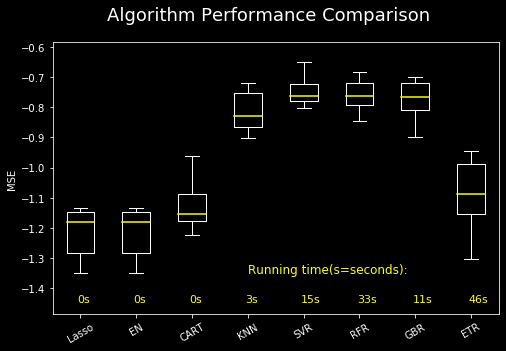

In [378]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, 
            boxprops=boxprops,
            medianprops=medianprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            showfliers=True, 
            flierprops=flierprops)

x_values = list(range(1,len(run_sec)+1))
y_max = pd.DataFrame(results_model).max().max()
y_min = pd.DataFrame(results_model).min().min()

plt.text(s="Running time(s=seconds):", x = 4, y = y_min, color="yellow", fontsize=12) 
plt.ylim(y_min + 0.1*y_min, y_max - 0.1*y_max)
for i in range(len(x_values)):
    plt.text(s=run_sec[i], x = x_values[i]-0.05, y = y_min + 0.07*y_min, color="yellow", fontsize=11)  

ax = fig.add_subplot(111)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("MSE")

plt.savefig("figures/algo_comparisson_drug.png", dpi=400, bbox_inches="tight")

plt.show()

The above analysis revealed **Support Vector Machine (SVM)** and **Random Forest Regressor (RFR)** as the most promissing models. Lets fine tune them using GridSearchCV.

**5.3: Fine Tunning and Model Evaluation**

In [294]:
# GridSearchCV
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"] 
C = [2, 3, 4] # higher values lower regularization
epsilon = [0.2, 0.3, 0.4] # lower values lower regularization
tol = [0.002]

param_grid = dict(kernel=kernel, C=C, epsilon=epsilon, tol=tol)

model = SVR()
KF = KFold(n_splits=5, random_state=42) 
grid = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s"
      % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best  -0.758105 using {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}

Best: -0.758105 using {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.758105 (0.048389) with: {'C': 2, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.759795 (0.049171) with: {'C': 2, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.763106 (0.051293) with: {'C': 2, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-0.765272 (0.047047) with: {'C': 3, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.764321 (0.046633) with: {'C': 3, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.767056 (0.048498) with: {'C': 3, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}
-0.773371 (0.046178) with: {'C': 4, 'epsilon': 0.2, 'kernel': 'rbf', 'tol': 0.002}
-0.771148 (0.045009) with: {'C': 4, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.002}
-0.771923 (0.049438) with: {'C': 4, 'epsilon': 0.4, 'kernel': 'rbf', 'tol': 0.002}


In [89]:
SVReg = SVR(C=3, epsilon=0, tol=0.015) # 
SVReg.fit(X_train,y_train) # 50, 12, 1, 4

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.015, verbose=False)

In [90]:
score_train_SVReg = round(SVReg.score(X_train,y_train),3) 

In [91]:
score_train_SVReg

0.603

In [92]:
score_test_SVReg = round(SVReg.score(X_test,y_test),3) 

In [93]:
score_test_SVReg

0.429

After Tunning RFR we obtained a better result:
    
    -0.658591 using {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 45}
    
Lets see how it performs with the test set

In [94]:
# After trying different combinations we reached the following model 
RFReg = RandomForestRegressor(n_estimators=45, max_depth=10, min_samples_leaf=4, min_samples_split=2) # 
RFReg.fit(X_train,y_train) # 50, 12, 1, 4

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=45, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [95]:
score_train_RFReg = round(RFReg.score(X_train,y_train),3) 

In [96]:
score_train_RFReg

0.596

In [97]:
score_test_RFReg = round(RFReg.score(X_test,y_test),3) 

In [98]:
score_test_RFReg

0.478

In [99]:
y_pred = RFReg.predict(X_test)
y_pred= y_pred.reshape(-1,1)

In [100]:
metrics.mean_squared_error(y_test, y_pred)

0.6604058007600125

In [101]:
metrics.mean_absolute_error(y_test, y_pred)

0.60454214326872

I will now create a scatter plot including the test and the predicted data.

In [102]:
(y_test.reshape(-1,1)).shape

(675, 1)

In [103]:
y_pred.shape

(675, 1)

In [104]:
df_scatter = pd.DataFrame(np.concatenate((y_test.reshape(-1,1), y_pred), axis=1), columns=["y_test_pIC50", "y_pred_pIC50"])

In [105]:
df_scatter

,y_test_pIC50,y_pred_pIC50
0,5.371815,5.349730
1,6.769551,6.660771
2,5.283579,5.646393
3,5.301030,6.656953
4,5.306713,5.334748
...,...,...
670,5.399790,5.308601
671,8.229148,6.741740
672,5.568636,5.848181
673,5.370590,6.334623


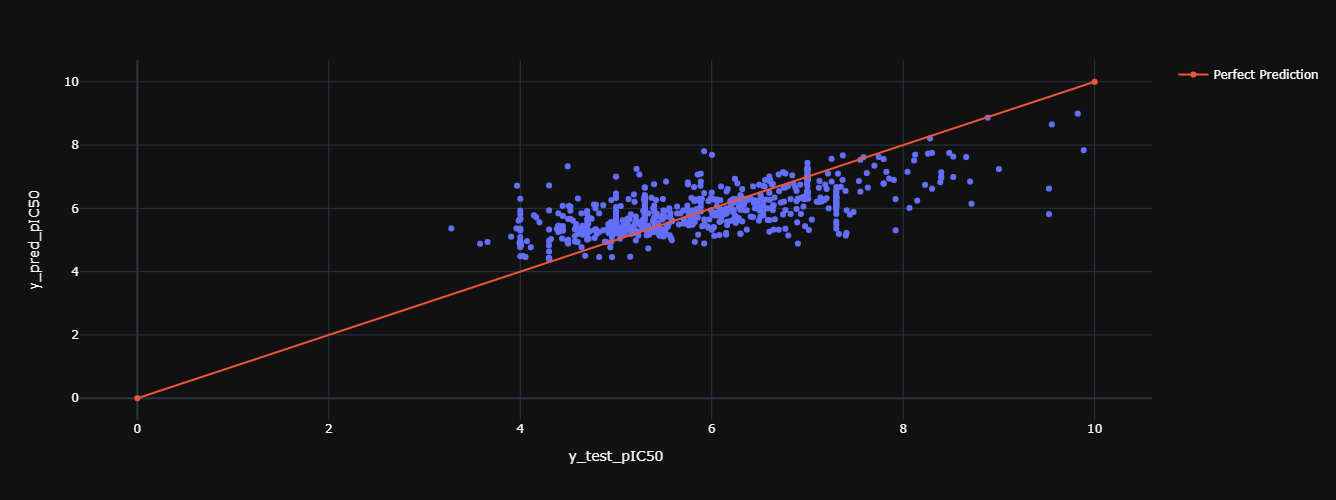

In [108]:
fig = px.scatter(df_scatter,
                x="y_test_pIC50", 
                y="y_pred_pIC50",
                hover_name=df_scatter.index,
                hover_data=[df_scatter.index],
                template="plotly_dark", width=700, height=500)
fig.add_trace(go.Line(x=[0,10], y=[0,10], name="Perfect Prediction"))
fig.show()

We observe how predicting the extremes is harder for the model

**Feature importance**

In [109]:
feat_imp = pd.Series(RFReg.feature_importances_)
features = pd.Series(X.columns)

In [110]:
len(features)

207

In [111]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [112]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

In [113]:
cumulative_importance_other = feature_importance[20:]["Importance"].sum()

In [114]:
rest_of_features = pd.DataFrame(["rest_of_features(187)", cumulative_importance_other])

In [115]:
rest_of_features = rest_of_features.T

In [116]:
rest_of_features.columns = ["Feature", "Importance"]

In [117]:
thirteen_top_features = feature_importance[:13]

In [118]:
feature_importance = pd.concat((thirteen_top_features, rest_of_features), axis=0).reset_index(drop=True)

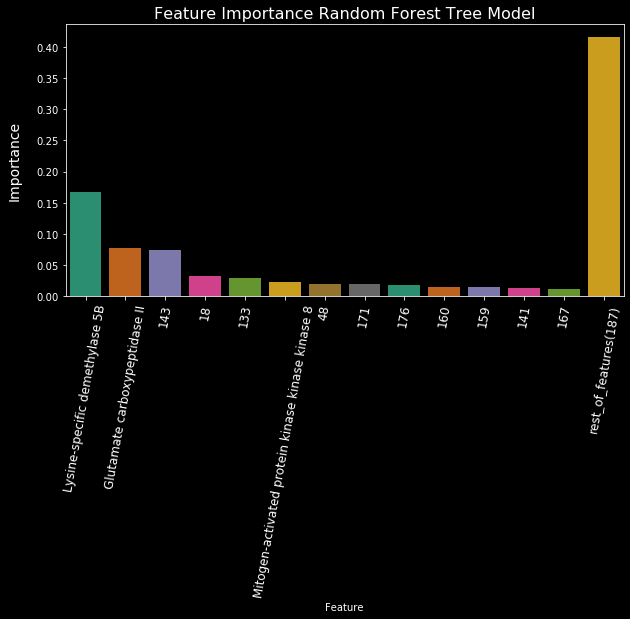

In [119]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Dark2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=80, fontsize=12)
plt.ylabel("Importance", labelpad=15, fontsize=14)
plt.title("Feature Importance Random Forest Tree Model", fontsize=16)
# Splt.savefig(r"D:\Projects\GitHub_drug_discovery\figures\Feature_importance_drugs.png", dpi=400, bbox_inches="tight")
plt.show()

In [120]:
y_pred = RFReg.predict(X)
y_pred= y_pred.reshape(-1,1)
(y.reshape(-1,1)).shape

(3375, 1)

In [121]:
df_scatter_all = pd.DataFrame(np.concatenate((y.reshape(-1,1), y_pred), axis=1), columns=["y_pIC50", "y_pred_pIC50"])

In [122]:
df_scatter_all = pd.concat([df_scatter_all, df["target_pref_name"]], axis=1)

In [123]:
df_scatter_all

,y_pIC50,y_pred_pIC50,target_pref_name
0,5.000000,5.347650,Alpha-ketoglutarate-dependent dioxygenase alkB...
1,5.000000,5.589604,Alpha-ketoglutarate-dependent dioxygenase alkB...
2,5.000000,5.589604,Alpha-ketoglutarate-dependent dioxygenase alkB...
3,5.000000,5.732090,Alpha-ketoglutarate-dependent dioxygenase alkB...
4,5.000000,5.226626,Alpha-ketoglutarate-dependent dioxygenase alkB...
...,...,...,...
3370,5.841638,5.776192,26S proteasome
3371,8.244125,6.602312,26S proteasome
3372,7.537602,6.461423,26S proteasome
3373,5.638272,6.056581,26S proteasome


In [138]:
fig = px.scatter(df_scatter_all,
                x="y_pIC50", 
                y="y_pred_pIC50",
                color="target_pref_name", 
                opacity=0.5,
                size = "y_pIC50",
                hover_name=df_scatter_all.index,
                hover_data=["target_pref_name",df_scatter_all.index],
                template="plotly_dark", width=1000, height=500)
fig.add_trace(go.Line(x=[0,10], y=[0,10], name="Perfect Prediction"))
fig.show(renderer="iframe")

In [134]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

## 6. Conclussions

**6.1 PubChem features** 

We observe that, based on our model, the PubChem features that seem to be most important in determining the activity of a drug are:
* 143
* 18
* 133
* 171
* 176
* 48...

It would be interesting to investigate this further and try to associate this with the activity of the drug, which could sed some light into possible modes of action, and development of more effective drugs.

**6.2 Molecular Cancer Target Groups** 🎯

We also see that:
* **Lysine-specific demethylase 5B (KDM5B)**
* **Glutamate carboxipeptidase II (GCPII)**
* **Mitogen-activated protein kinase 8 (MAP3K8)**

They have the largest activities among all molecular targets. Hence they may be the **best targets to develop drugs for treating cancer**.

**6.3 Literature**. 📚 

To continue this project would be interesting to further study this three proteins:

* Nice Review for **KDM5B**: [2017  KDM5B in development and cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5352456/) ->  "*Given its association with tumor progression and prognosis of cancer patients, KDM5B was proposed to be a novel target for the prevention and treatment of human cancers*".

* Furthemore, It seems that there is already a strong focus on finding inhibitors of **GCPII**: [2019 Structural and computational basis for potent inhibition of glutamate carboxypeptidase II by carbamate-based inhibitors](https://www.sciencedirect.com/science/article/abs/pii/S0968089618316110). *"These insights should be of particular importance in future efforts to design and develop GCPII inhibitors for optimal inhibitory potency"*

* MAP3K8 acts as a tumor suppressor, and there is a **significant elevation in the cancer tissue or/and cells**. **Nonetheless, this may not be a good molecular target** since MAPK 8 acts as a MAP3K and is widely expressed in the brain, intestine, kidney, skeletal muscles, and the immunological system, hence a drug could have multiple adverse effects. [Read more in this paper from 2015](https://academic.oup.com/mend/article/29/5/703/2556237).

In the picture below we can see the chemical structure of **three potential drugs targetting Glutamate carboxipeptidase II** described in the 2019 paper above.

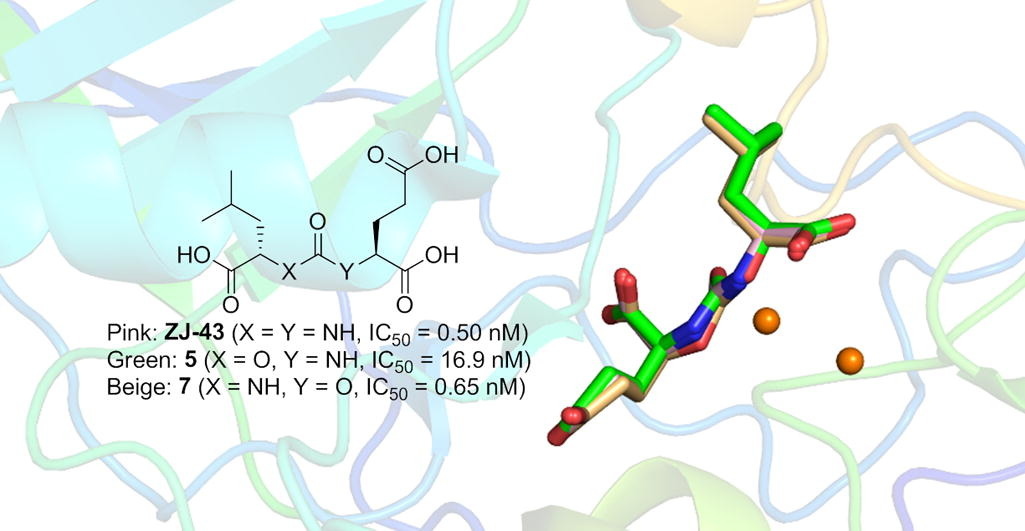

In [430]:
Image(filename=r"D:\Projects\GitHub_drug_discovery\figures\candidate_drugs_GCII.jpg", width=500, height=500) 